# Human Failure Representation

This paper covers the exploration and analysis of error producing conditions by a human operator in the rover model.

In [1]:
from examples.rover.rover_model_human import RoverHuman
from examples.rover.rover_model import plot_map

import fmdtools.sim.propagate as prop
import fmdtools.analyze as an
from fmdtools.sim.sample import ParameterSample, ParameterDomain, FaultSample, FaultDomain

import numpy as np
import matplotlib.pyplot as plt

Visualizing Rover Structure

In [ ]:
mdl = RoverHuman()
mdl.fxns

{'power': power Power
 - PowerState(charge=100.0, power=0.0)
 - PowerMode(mode=off, faults=set()),
 'perception': perception Perception
 - PerceptionMode(mode=off, faults=set()),
 'communications': communications Communications,
 'operator': operator Operator
 - Mode(mode=nominal, faults=set()),
 'plan_path': plan_path PlanPath
 - PlanPathState(u_self=array([0., 0.]), u_lin=array([0., 0.]), u_lin_dev=array([0., 0.]), rdiff=0.0, vel_adj=1.0)
 - PlanPathMode(mode=standby, faults=set()),
 'override': override Override
 - OverrideMode(mode=off, faults=set()),
 'drive': drive Drive
 - FaultStates(transfer=1.0, friction=0.0, drift=0.0)
 - DriveMode(mode=nominal, faults=set())}

In [3]:
#%matplotlib qt
#an.graph.set_pos(mdl, gtype='fxnflowgraph')

In [4]:
#%matplotlib inline

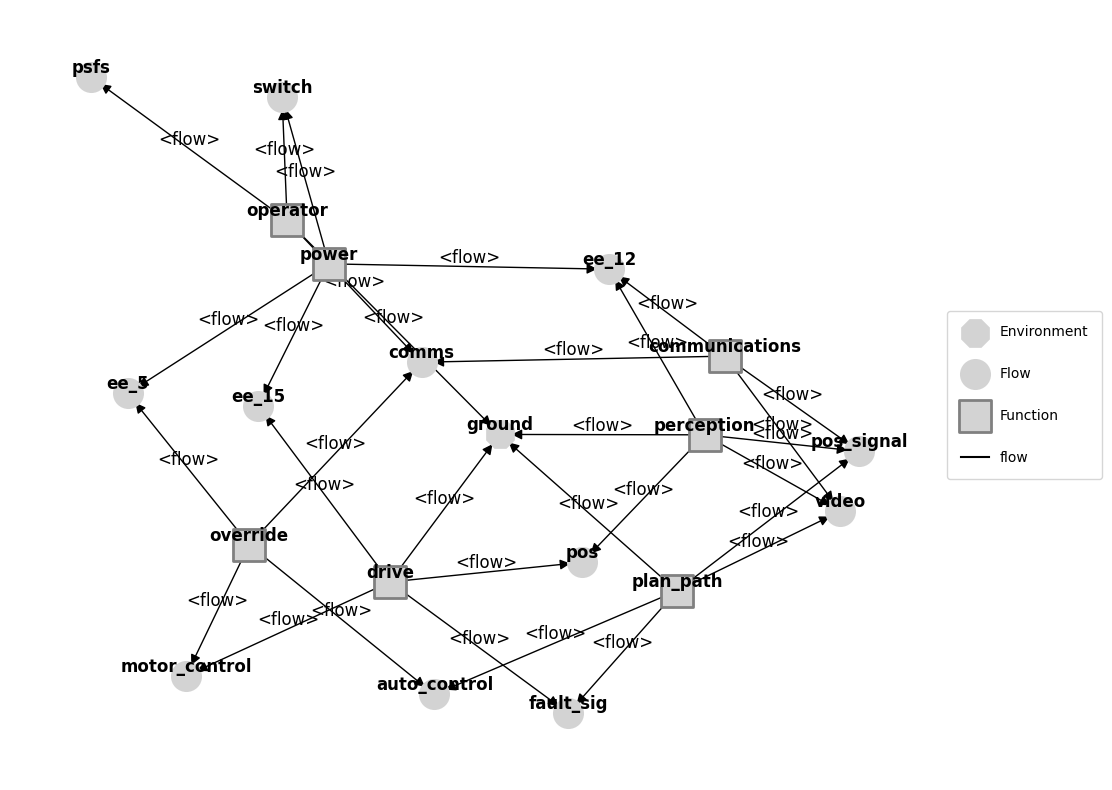

In [5]:
g = mdl.as_modelgraph()
fig, ax = g.draw()

In [6]:
fig.savefig("rover_structure.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Visualizing Action Sequence Graph for the Controller

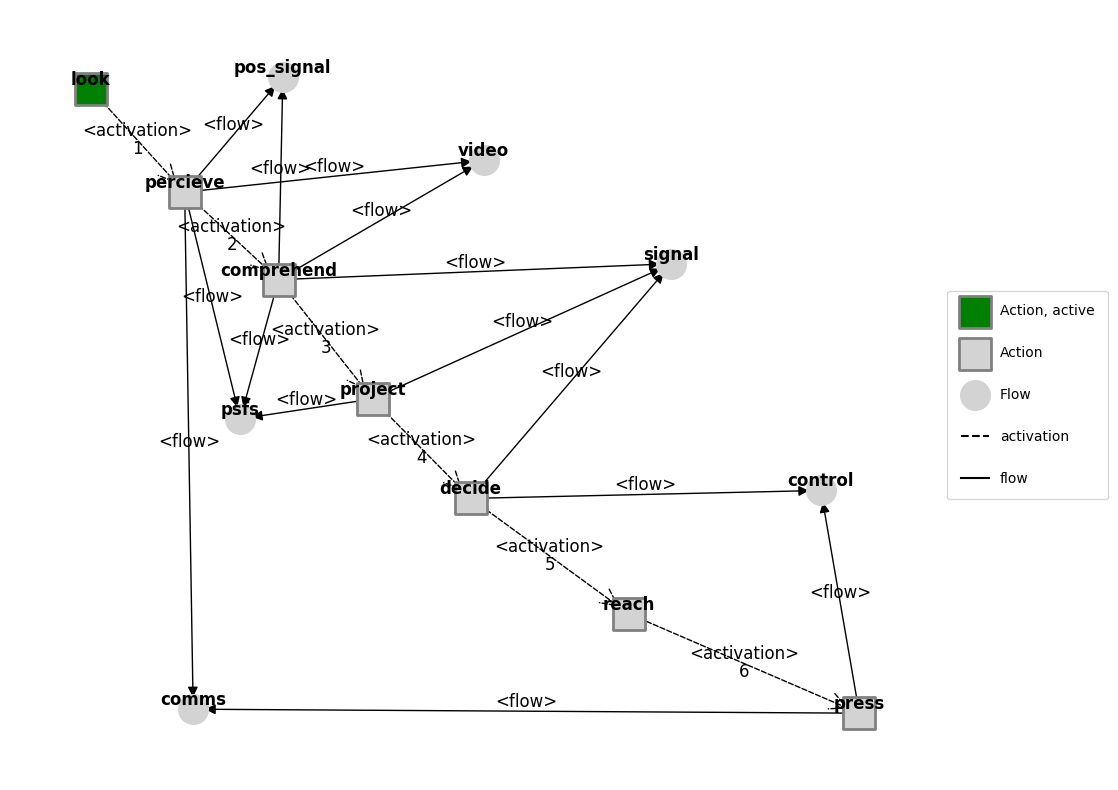

In [7]:
from examples.rover.rover_model_human import asg_pos
ag = mdl.fxns['operator'].aa.as_modelgraph()
ag.set_pos(**asg_pos)
fig, ax = ag.draw()

In [8]:
fig.savefig("action_graph.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

## Testing behavioral simulation

Execution order

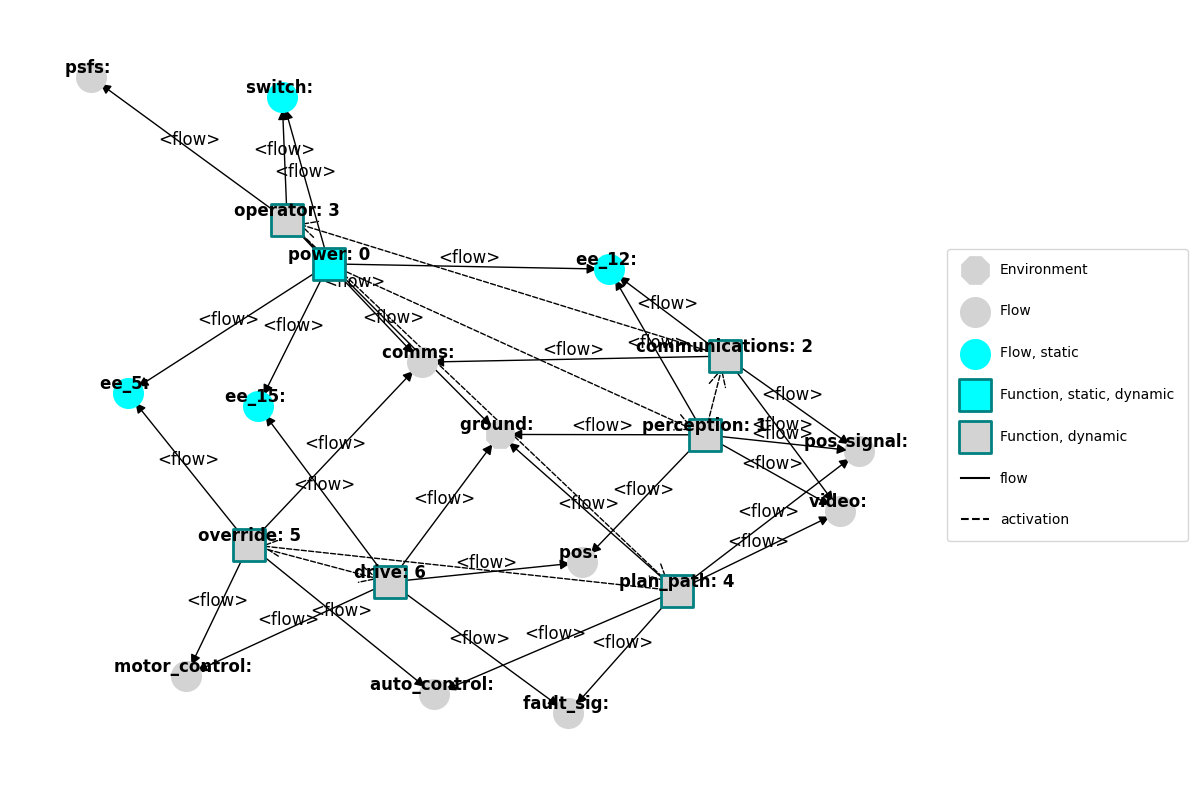

In [9]:
g.set_exec_order(mdl)
fig, ax = g.draw()

Performance on turn

(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

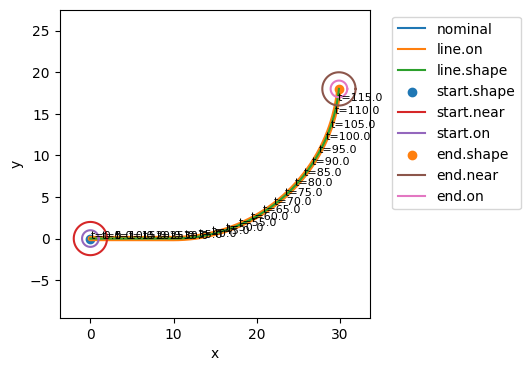

In [10]:
mdl = RoverHuman(p={'ground': 'turn'})
endresults, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

Performance on sine map

(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

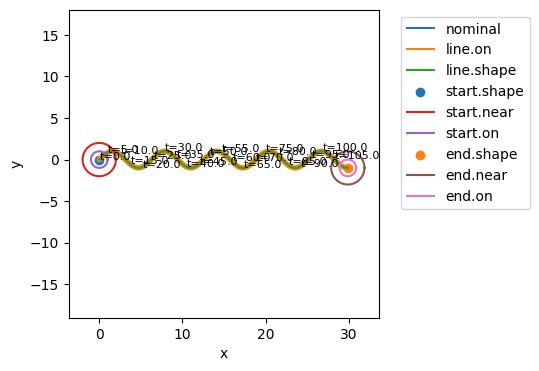

In [11]:
mdl = RoverHuman()
endresults, mdlhist = prop.nominal(mdl)
plot_map(mdl, mdlhist)

In [12]:
from fmdtools.analyze.phases import from_hist
pm = from_hist(mdlhist)

In [13]:
pm

{'power': PhaseMap({'off': [0.0, 0.0], 'supply': [1.0, 109.0]}, {'off': {'off'}, 'supply': {'supply'}}),
 'perception': PhaseMap({'off': [0.0, 1.0], 'feed': [2.0, 109.0]}, {'off': {'off'}, 'feed': {'feed'}}),
 'look': PhaseMap({'nominal': [0.0, 109.0]}, {'nominal': {'nominal'}}),
 'percieve': PhaseMap({'no_action': [0.0, 1.0], 'nominal': [2.0, 109.0]}, {'no_action': {'no_action'}, 'nominal': {'nominal'}}),
 'comprehend': PhaseMap({'nominal': [0.0, 109.0]}, {'nominal': {'nominal'}}),
 'project': PhaseMap({'nominal': [0.0, 109.0]}, {'nominal': {'nominal'}}),
 'decide': PhaseMap({'nominal': [0.0, 109.0]}, {'nominal': {'nominal'}}),
 'reach': PhaseMap({'nominal': [0.0, 109.0]}, {'nominal': {'nominal'}}),
 'plan_path': PhaseMap({'standby': [0.0, 4.0], 'drive': [5.0, 109.0]}, {'standby': {'standby'}, 'drive': {'drive'}}),
 'override': PhaseMap({'off': [0.0, 1.0], 'override': [2.0, 109.0]}, {'off': {'off'}, 'override': {'override'}})}

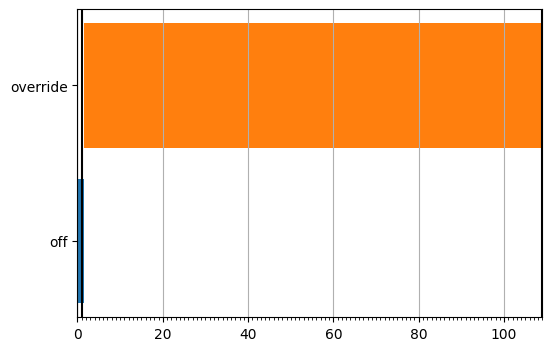

In [14]:
phase_fig = pm['override'].plot()

## Testing Faults

In [15]:
#app=SampleApproach(mdl, faults='Controller', phases={'drive':phases['Operations']['drive']})

fd = FaultDomain(mdl)
fd.add_all_fxn_modes('operator')
fd

FaultDomain with faults:
 -('roverhuman.fxns.operator.aa.acts.look', 'failed_no_action')
 -('roverhuman.fxns.operator.aa.acts.percieve', 'failed_no_action')
 -('roverhuman.fxns.operator.aa.acts.percieve', 'not_visible')
 -('roverhuman.fxns.operator.aa.acts.percieve', 'wrong_position')
 -('roverhuman.fxns.operator.aa.acts.comprehend', 'failed_no_action')
 -('roverhuman.fxns.operator.aa.acts.project', 'failed_fast')
 -('roverhuman.fxns.operator.aa.acts.project', 'failed_no_action')
 -('roverhuman.fxns.operator.aa.acts.project', 'failed_slow')
 -('roverhuman.fxns.operator.aa.acts.project', 'failed_turn_left')
 -('roverhuman.fxns.operator.aa.acts.project', 'failed_turn_right')
 -...more

In [16]:
fs = FaultSample(fd, phasemap = pm['override'])
fs.add_fault_phases('override')
fs

FaultSample of scenarios: 
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t56p0
 - roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t56p0
 - roverhuman_fxns_operator_aa_acts_percieve_not_visible_t56p0
 - roverhuman_fxns_operator_aa_acts_percieve_wrong_position_t56p0
 - roverhuman_fxns_operator_aa_acts_comprehend_failed_no_action_t56p0
 - roverhuman_fxns_operator_aa_acts_project_failed_fast_t56p0
 - roverhuman_fxns_operator_aa_acts_project_failed_no_action_t56p0
 - roverhuman_fxns_operator_aa_acts_project_failed_slow_t56p0
 - roverhuman_fxns_operator_aa_acts_project_failed_turn_left_t56p0
 - roverhuman_fxns_operator_aa_acts_project_failed_turn_right_t56p0
 - ... (19 total)

In [17]:
fs.scenarios()

[SingleFaultScenario(sequence={56.0: Injection(faults={'roverhuman.fxns.operator.aa.acts.look': ['failed_no_action']}, disturbances={})}, times=(56.0,), function='roverhuman.fxns.operator.aa.acts.look', fault='failed_no_action', rate=1.0, name='roverhuman_fxns_operator_aa_acts_look_failed_no_action_t56p0', time=56.0, phase='override'),
 SingleFaultScenario(sequence={56.0: Injection(faults={'roverhuman.fxns.operator.aa.acts.percieve': ['failed_no_action']}, disturbances={})}, times=(56.0,), function='roverhuman.fxns.operator.aa.acts.percieve', fault='failed_no_action', rate=1.0, name='roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t56p0', time=56.0, phase='override'),
 SingleFaultScenario(sequence={56.0: Injection(faults={'roverhuman.fxns.operator.aa.acts.percieve': ['not_visible']}, disturbances={})}, times=(56.0,), function='roverhuman.fxns.operator.aa.acts.percieve', fault='not_visible', rate=1.0, name='roverhuman_fxns_operator_aa_acts_percieve_not_visible_t56p0', time=56

In [18]:
ecs, hists = prop.fault_sample(mdl, fs)

SCENARIOS COMPLETE: 100%|██████████| 19/19 [00:02<00:00,  7.65it/s]


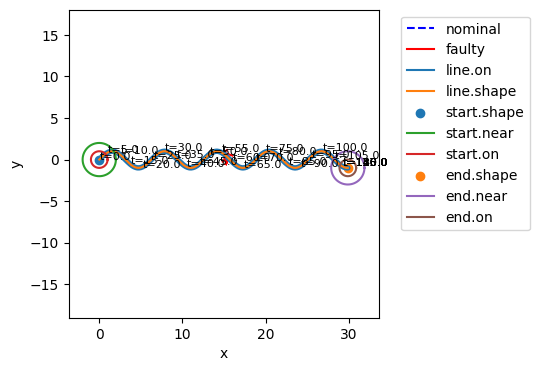

In [19]:
fig, ax = plot_map(mdl, hists)

(-5.0, 5.0)

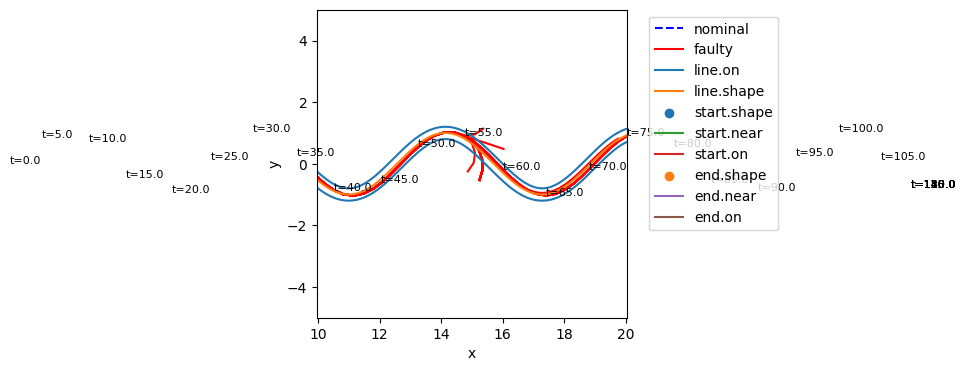

In [20]:
fig, ax = plot_map(mdl, hists)
ax.set_xlim(10, 20)
ax.set_ylim(-5, 5)

In [21]:
fig.savefig("rover_map.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

Below shows the impact of each fault:

In [22]:
tab = an.tabulate.result_summary_fmea(ecs, hists,
                                      *mdl.flows, *mdl.fxns,
                                      metrics = ["in_bound", "at_finish", "end_dist", "faults", "classification", "end_x", "end_y"])
tab

,degraded,faulty,in_bound,at_finish,end_dist,faults,classification,end_x,end_y
roverhuman_fxns_operator_aa_acts_look_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,[look.failed_no_action],incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t56p0,['ground'],[],True,True,0.0,[],nominal mission,29.254775,-0.782764
roverhuman_fxns_operator_aa_acts_percieve_not_visible_t56p0,['ground'],[],True,True,0.0,[],nominal mission,29.254775,-0.782764
roverhuman_fxns_operator_aa_acts_percieve_wrong_position_t56p0,['ground'],[],True,True,0.0,[],nominal mission,29.254775,-0.782764
roverhuman_fxns_operator_aa_acts_comprehend_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, comprehend.failed_no_ac...",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_project_failed_fast_t56p0,"['ground', 'pos_signal', 'pos', 'ee_15', 'vide...",['operator'],False,False,12.955107,"[percieve.not_visible, project.failed_fast]",incomplete mission faulty,16.023518,0.480458
roverhuman_fxns_operator_aa_acts_project_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, project.failed_no_action]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_project_failed_slow_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'ee_12...",['operator'],True,False,9.31949,[project.failed_slow],incomplete mission faulty,19.740872,0.81243
roverhuman_fxns_operator_aa_acts_project_failed_turn_left_t56p0,"['ground', 'pos_signal', 'pos', 'video', 'auto...",['operator'],False,False,14.057688,"[percieve.not_visible, project.failed_turn_left]",incomplete mission faulty,14.862043,-0.251773
roverhuman_fxns_operator_aa_acts_project_failed_turn_right_t56p0,"['ground', 'pos_signal', 'pos', 'video', 'auto...",['operator'],False,False,13.693675,"[percieve.not_visible, project.failed_turn_right]",incomplete mission faulty,15.363988,1.140047


In [23]:
tab.sort_values('end_dist', ascending=False)

,degraded,faulty,in_bound,at_finish,end_dist,faults,classification,end_x,end_y
roverhuman_fxns_operator_aa_acts_project_failed_turn_left_t56p0,"['ground', 'pos_signal', 'pos', 'video', 'auto...",['operator'],False,False,14.057688,"[percieve.not_visible, project.failed_turn_left]",incomplete mission faulty,14.862043,-0.251773
roverhuman_fxns_operator_aa_acts_project_failed_turn_right_t56p0,"['ground', 'pos_signal', 'pos', 'video', 'auto...",['operator'],False,False,13.693675,"[percieve.not_visible, project.failed_turn_right]",incomplete mission faulty,15.363988,1.140047
roverhuman_fxns_operator_aa_acts_look_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,[look.failed_no_action],incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_reach_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, reach.failed_no_action]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_decide_failed_turn_right_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, decide.failed_turn_right]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_decide_failed_turn_left_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, decide.failed_turn_left]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_decide_failed_slow_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, decide.failed_slow]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_decide_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, decide.failed_no_action]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_decide_failed_fast_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, decide.failed_fast]",incomplete mission faulty,15.24424,-0.529458
roverhuman_fxns_operator_aa_acts_project_failed_no_action_t56p0,"['ground', 'psfs', 'pos_signal', 'pos', 'video...",['operator'],False,False,13.663813,"[percieve.not_visible, project.failed_no_action]",incomplete mission faulty,15.24424,-0.529458


In [24]:
print(tab.to_latex())

\begin{tabular}{llllllllll}
\toprule
 & degraded & faulty & in_bound & at_finish & end_dist & faults & classification & end_x & end_y \\
\midrule
roverhuman_fxns_operator_aa_acts_look_failed_no_action_t56p0 & ['ground', 'psfs', 'pos_signal', 'pos', 'video', 'auto_control', 'motor_control', 'comms', 'power', 'operator', 'plan_path'] & ['operator'] & False & False & 13.663813 & ['look.failed_no_action'] & incomplete mission faulty & 15.244240 & -0.529458 \\
roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t56p0 & ['ground'] & [] & True & True & 0.000000 & [] & nominal mission & 29.254775 & -0.782764 \\
roverhuman_fxns_operator_aa_acts_percieve_not_visible_t56p0 & ['ground'] & [] & True & True & 0.000000 & [] & nominal mission & 29.254775 & -0.782764 \\
roverhuman_fxns_operator_aa_acts_percieve_wrong_position_t56p0 & ['ground'] & [] & True & True & 0.000000 & [] & nominal mission & 29.254775 & -0.782764 \\
roverhuman_fxns_operator_aa_acts_comprehend_failed_no_action_t56p0 & ['gr

As shown, most modes now have an effect.

## Examining Performance Shaping Factors

In [25]:
from examples.rover.rover_model_human import RoverHumanParam
pd = ParameterDomain(RoverHumanParam)
#pd.add_constant('ground.linetype', 'sine')
#pd.add_constant('ground.amp', 4)
pd.add_variable('psfs.fatigue', var_lim=(0, 11))
pd.add_variable('psfs.attention', var_lim=(0, 11))
pd

ParameterDomain with:
 - variables: {'psfs.fatigue': (0, 11), 'psfs.attention': (0, 11)}
 - constants: {}
 - parameter_initializer: RoverHumanParam

In [26]:
ps = ParameterSample(pd)
ps.add_variable_ranges(comb_kwargs={'resolution': 1})
ps

ParameterSample of scenarios:
 - rep0_range_0
 - rep0_range_1
 - rep0_range_2
 - rep0_range_3
 - rep0_range_4
 - rep0_range_5
 - rep0_range_6
 - rep0_range_7
 - rep0_range_8
 - rep0_range_9
 - ... (144 total)

In [27]:
ps.scenarios()

[ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0, 'attention': 0}}, r={}, sp={}, prob=0.006944444444444444, inputparams={0: 0, 1: 0}, rangeid='', name='rep0_range_0'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0, 'attention': 1}}, r={}, sp={}, prob=0.006944444444444444, inputparams={0: 0, 1: 1}, rangeid='', name='rep0_range_1'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0, 'attention': 2}}, r={}, sp={}, prob=0.006944444444444444, inputparams={0: 0, 1: 2}, rangeid='', name='rep0_range_2'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0, 'attention': 3}}, r={}, sp={}, prob=0.006944444444444444, inputparams={0: 0, 1: 3}, rangeid='', name='rep0_range_3'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0, 'attention': 4}}, r={}, sp={}, prob=0.006944444444444444, inputparams={0: 0, 1: 4}, rangeid='', name='rep0_range_4'),
 ParameterScenario(sequence={}, times=(), p={'psfs': {'fatigue': 0, 'a

In [28]:
ers, hists = prop.parameter_sample(mdl, ps)

SCENARIOS COMPLETE: 100%|██████████| 144/144 [00:32<00:00,  4.47it/s]


(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

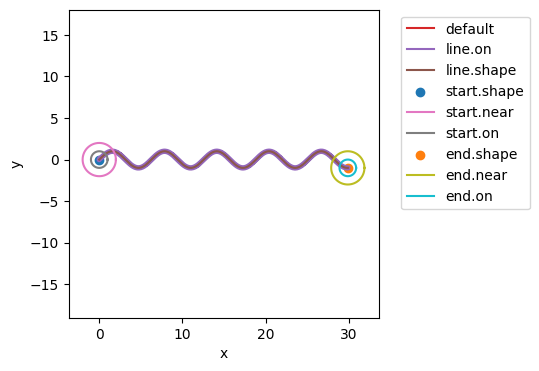

In [29]:
plot_map(mdl, hists)

In [30]:
ers.get_values("end_x")

rep0_range_0.endclass.end_x: 29.254775331608617
rep0_range_1.endclass.end_x: 29.254775331608617
rep0_range_2.endclass.end_x: 29.254775331608617
rep0_range_3.endclass.end_x: 29.254775331608617
rep0_range_4.endclass.end_x: 29.254775331608617
rep0_range_5.endclass.end_x: 29.254775331608617
rep0_range_6.endclass.end_x: 29.254775331608617
rep0_range_7.endclass.end_x: 29.254775331608617
rep0_range_8.endclass.end_x: 29.254775331608617
rep0_range_9.endclass.end_x: 29.254775331608617
rep0_range_10.endclass.end_x: 29.254775331608617
rep0_range_11.endclass.end_x: 29.254775331608617
rep0_range_12.endclass.end_x: 29.254775331608617
rep0_range_13.endclass.end_x: 29.254775331608617
rep0_range_14.endclass.end_x: 29.254775331608617
rep0_range_15.endclass.end_x: 29.254775331608617
rep0_range_16.endclass.end_x: 29.254775331608617
rep0_range_17.endclass.end_x: 29.254775331608617
rep0_range_18.endclass.end_x: 29.254775331608617
rep0_range_19.endclass.end_x: 29.254775331608617
rep0_range_20.endclass.end_x: 

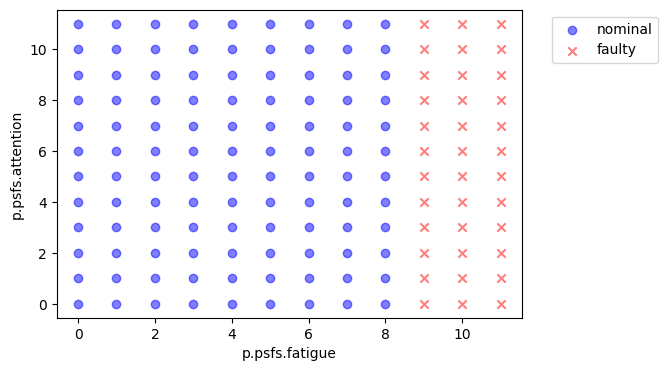

In [31]:
from fmdtools.analyze.tabulate import NominalEnvelope
na = NominalEnvelope(ps, ers, 'at_finish', 'p.psfs.fatigue', 'p.psfs.attention', func= lambda x: x)
fig, ax = na.plot_scatter()

In [32]:
fig.savefig("nominal_psfs.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [34]:
mdl = RoverHuman(p={'ground': {'linetype': 'turn'}})
endresults, mdlhist = prop.one_fault(mdl, 'operator.aa.acts.look', 'failed_no_action', time=15)

In [35]:
endresults

endclass.rate:                       1.0
endclass.cost:                         0
endclass.prob:                       1.0
endclass.expected_cost:                0
endclass.in_bound:                 False
endclass.at_finish:                False
endclass.line_dist:                    1
endclass.num_modes:                    1
endclass.end_dist:    23.466067426611588
endclass.tot_deviation: 0.2759017544282031
endclass.faults:                array(1)
endclass.classification: incomplete mission faulty
endclass.end_x:        13.33333333333334
endclass.end_y:                      0.0
endclass.endpt:                 array(2)

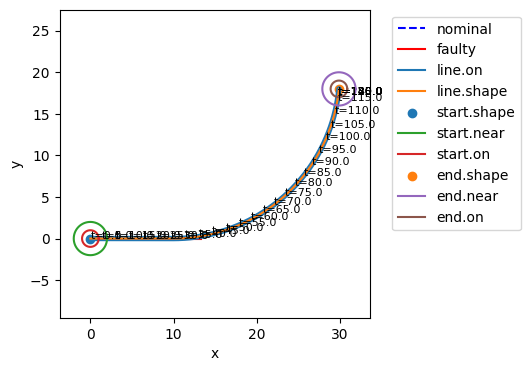

In [36]:
traj_fig = plot_map(mdl, mdlhist)

(<Figure size 400x400 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

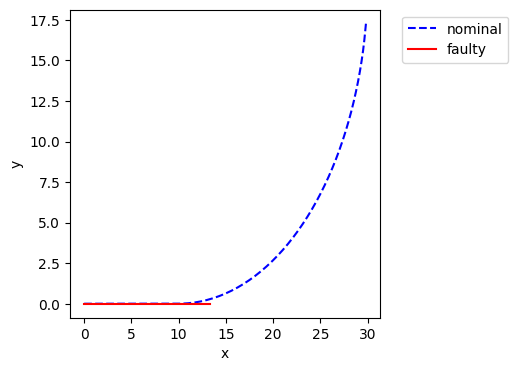

In [37]:
mdlhist.plot_trajectories('flows.pos.s.x', 'flows.pos.s.y')

(<Figure size 600x400 with 4 Axes>,
 array([<Axes: title={'center': 'flows.pos.s.vel'}, xlabel=' '>,
        <Axes: title={'center': 'flows.pos.s.ux'}, xlabel='time'>,
        <Axes: title={'center': 'flows.pos.s.uy'}, xlabel='time'>,
        <Axes: >], dtype=object))

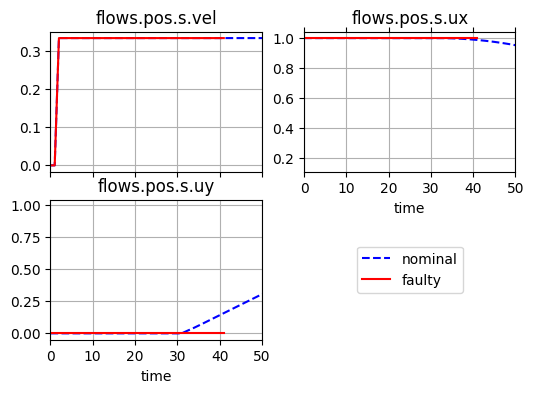

In [38]:
mdlhist.plot_line('flows.pos.s.vel', 'flows.pos.s.ux', 'flows.pos.s.uy')

In [39]:
fs = FaultSample(fd)
fs.add_fault_times([j for j in range(0, 30, 5)])
fs

FaultSample of scenarios: 
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t0
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t5
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t10
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t15
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t20
 - roverhuman_fxns_operator_aa_acts_look_failed_no_action_t25
 - roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t0
 - roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t5
 - roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t10
 - roverhuman_fxns_operator_aa_acts_percieve_failed_no_action_t15
 - ... (114 total)

In [40]:
ers, hists = prop.fault_sample(mdl, fs)

SCENARIOS COMPLETE: 100%|██████████| 114/114 [00:14<00:00,  7.73it/s]


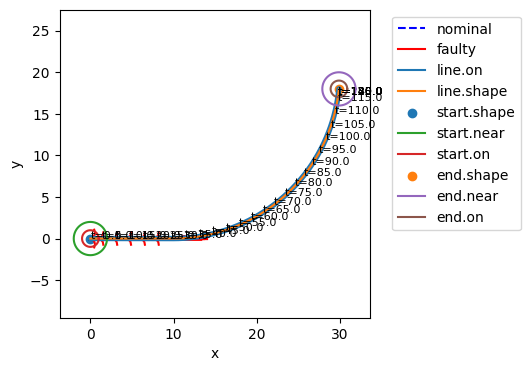

In [41]:
fig, ax = plot_map(mdl, hists)

In [42]:
fig.savefig("nocon_trajectories.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

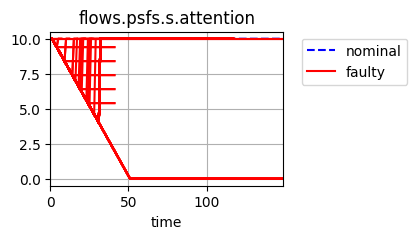

In [43]:
fig, ax = hists.plot_line('flows.psfs.s.attention')

In [44]:
fig.savefig("nocon_attention.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

In [45]:
mdl = RoverHuman(p={'ground': {'linetype': 'sine', 'amp': 2, 'period': 2/3.14*30}})

In [46]:
ers, hists = prop.fault_sample(mdl, fs)

SCENARIOS COMPLETE: 100%|██████████| 114/114 [00:12<00:00,  8.79it/s]


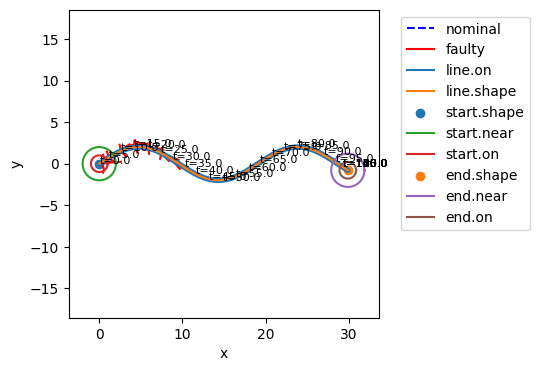

In [47]:
fig, ax = plot_map(mdl, hists)

In [48]:
fig.savefig("nocon_trajectories_sine.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)

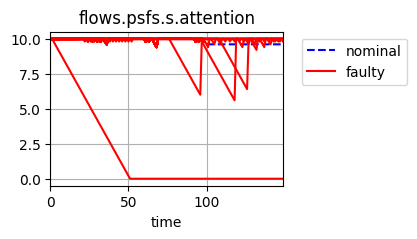

In [49]:
fig, ax = hists.plot_line('flows.psfs.s.attention')

In [50]:
fig.savefig("nocon_attention_sine.pdf", format="pdf", bbox_inches = 'tight', pad_inches = 0)